In [18]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import matplotlib.pyplot as plt
import flax
from typing import Any
import numpy as np
import optax

# Model Agnostic Meta Learning

**Meta-learning** is the idea of learning *how to learn*. Meta-learning is often assossiated with the **few-shot learning** challenge -- how can a network learn to quickly solve new tasks, when given only a few $(< 100)$ examples? Whereas in standard machine learning we have a dataset of data points, in few-shot learning we generally want a dataset of *tasks*. For example, the character classification *meta*-task is to classify a new set of K characters, given a few examples of each class. We'll often call this final evaluation the **downstream** task.

In the specific example of **model agnostic meta learning (MAML)**, we'd like to learn a set of neural network parameters such that a small number of gradient descent steps is enough to solve a new task. The intution here is that gradient descent is good, and if we have some data for our downstream task, we should run gradient descent on it. Some kinds of parameters are inherently good at *adapting* to new tasks, and we want to find these parameters.

Imagine a typical *inner-loop* optimization for the character classification task. We're given a set of task-specific input-output pairs (e.g. images and class labels), and we will run gradient descent. To evaluate, we will test our new model on some held-out validation data from the same task.

MAML tries to find a set of global parameters which are a good starting point for the above inner-loop process. It achieves this by taking a gradient *through* the optimization process. 

## Example: Sine wave regression

We'll take an example from the MAML paper. Given a few points from a sine wave of random phase and amplitude, the task is to predict the rest of the points.

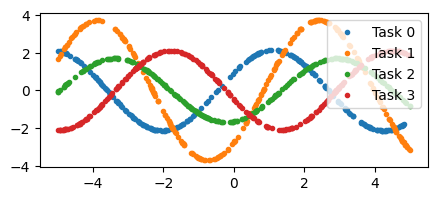

In [39]:
# From: https://github.com/gcucurull/maml_flax
def generate_sinusoids(key, num_tasks, num_points):
    amp_key, phase_key, x_key = jax.random.split(key, 3)
    amp = jax.random.uniform(amp_key, minval=0.1, maxval=5.0, shape=(num_tasks, 1, 1))
    phase = jax.random.uniform(phase_key, minval=-np.pi, maxval=np.pi, shape=(num_tasks, 1, 1))
    samples_x = jax.random.uniform(x_key, minval=-5, maxval=5, shape=(num_tasks, num_points, 1))
    samples_y = amp * jnp.sin(samples_x + phase)
    return samples_x, samples_y

x, y = generate_sinusoids(jax.random.PRNGKey(3), 4, 256)

fig, axs = plt.subplots(1, 1, figsize=(5, 2))
for i in range(4):
    axs.plot(x[i], y[i], '.', label=f"Task {i}")

plt.legend(loc='upper right')

Let's start by defining a simple two-layer neural network, and overfitting to one of the downstream tasks. We'll sample a single sine wave, generate some data from it, then try to fit the function.

In [27]:
class Network(nn.Module):
    @nn.compact
    def __call__(self, x: np.ndarray) -> np.ndarray:
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=40)(x)
        x = nn.relu(x)
        x = nn.Dense(features=1)(x)
        return x

class TrainState(flax.struct.PyTreeNode):
    module: Any = flax.struct.field(pytree_node=False)
    opt: Any = flax.struct.field(pytree_node=False)
    params: Any
    opt_state: Any

def init_train_state():
    network = Network()
    params = network.init(jax.random.PRNGKey(0), jnp.zeros((1, 1)))
    opt = optax.adam(learning_rate=0.01)
    return TrainState(params=params, opt=opt, opt_state=opt.init(params), module=network)

@jax.jit
def update_fn(train_state, x, y):
    def loss_fn(grad_params):
        pred = train_state.module.apply(grad_params, x)
        return jnp.mean(jnp.square(pred - y))

    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

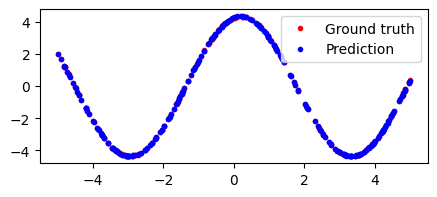

In [40]:
# Train network on a *single* sine wave.
train_state = init_train_state() # Make a new model.
x_all, y_all = generate_sinusoids(jax.random.PRNGKey(0), 1, 256)
key = jax.random.PRNGKey(0)
for i in range(1000):
    id_key, key = jax.random.split(key)
    batch_ids = jax.random.randint(id_key, shape=(32,), minval=0, maxval=x_all.shape[0])
    x, y = x_all[batch_ids], y_all[batch_ids]
    train_state, info = update_fn(train_state, x, y)

# Evaluate.
y_pred = train_state.module.apply(train_state.params, x_all)
plt.figure(figsize=(5, 2))
plt.plot(x_all[0], y_all[0], 'r.', label='Ground truth')
plt.plot(x_all[0], y_pred[0], 'b.', label='Prediction')
plt.legend(loc='upper right')
plt.show()

Cool, so we can overfit to a single sine wave pretty easily. 

Next, let's see how our network works on the few-shot task. We'll use a naive baseline -- just running SGD on samples taken from *random* tasks, i.e. different sine waves. We'll train our network this way, then to evaluate, we will take a few steps of gradient descent on a *new* sine wave, and see how good our network adapts.

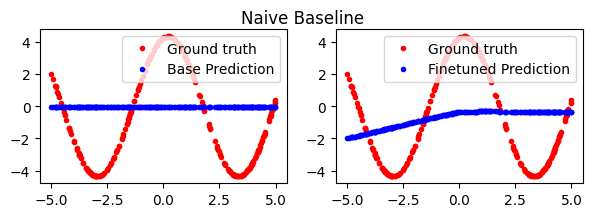

In [49]:
x_single, y_single = generate_sinusoids(jax.random.PRNGKey(0), 1, 256)

# Train network on a *all* sine waves.
train_state = init_train_state() # Make a new model.
key = jax.random.PRNGKey(0)
for i in range(1000):
    id_key, sine_key, key = jax.random.split(key, 3)
    x, y = generate_sinusoids(sine_key, 256, 1)
    train_state, info = update_fn(train_state, x[:, 0], y[:, 0])
y_pred_all = train_state.module.apply(train_state.params, x_single)

# 10-step finetune on a single sine wave.
for i in range(10):
    train_state, _ = update_fn(train_state, x_single[0, :32], y_single[0, :32])
y_pred_finetune = train_state.module.apply(train_state.params, x_single)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))
axs[0].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[0].plot(x_single[0], y_pred_all[0], 'b.', label='Base Prediction')
axs[1].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[1].plot(x_single[0], y_pred_finetune[0], 'b.', label='Finetuned Prediction')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
fig.suptitle('Naive Baseline')
plt.show()

The base prediction here is just all zeros. This should make sense; the average of all sine waves with phase $(-\pi, pi)$ is just the zero line after all. When we do some finetuning on our downstream task, the results are not great. We're unable to quickly adapt to the new sine wave.

Why does this happen? Somemtimes, learning the average over all tasks is a significantly different problem than learning each task individually. This behavior is especially true in our example -- the average is just a straight line! The features of our neural network don't need to learn anything smart about sine wave structure.

Next, let's try to tackle the problem using MAML. A basic outline of MAML is as follows:
- We start by sampling a set of $K$ tasks. In our case, this is different sine waves. For each task, we'll generate a set of training data and validation data.
- In the *inner loop*, we take our global parameters and take a gradient step on our task-specific training data. This give us updated *task-specific* parameters. Then, we evaluate loss of the task-specific parameters on the validation data. This is done in parallel for all $K$ tasks.
- In the *outer loop*, we take the gradient with respect to global parameters of the inner-loop validation loss. This means taking a gradient *of the inner gradient step*. 

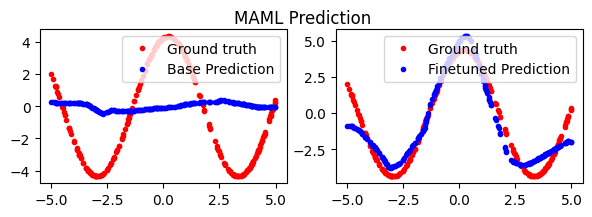

In [53]:
@jax.jit
def update_fn(train_state, batch): # MAML Update function.
    inner_steps = 1
    def maml_loss(task_params, train_x, train_y, val_x, val_y):
        def task_loss(params, x, y):
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for i in range(inner_steps): # Inner loop.
            model_grad = jax.grad(task_loss)(task_params, train_x, train_y)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
        loss = task_loss(task_params, val_x, val_y)
        return loss

    def loss_fn(grad_params): # Parallel map over K inner-loop tasks.
        maml_losses = jax.vmap(lambda task: maml_loss(grad_params, *task))(batch)
        return jnp.mean(maml_losses)

    l, g = jax.value_and_grad(loss_fn)(train_state.params) # Outer-loop gradient.
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

# Train network on a *all* sine waves.
train_state = init_train_state() # Make a new model.
key = jax.random.PRNGKey(0)
for i in range(1000):
    id_key, sine_key, key = jax.random.split(key, 3)
    x, y = generate_sinusoids(sine_key, 16, 64) # 16 tasks, with 64 datapoints each.
    inner_train_x, inner_val_x = np.split(x, 2, axis=1)
    inner_train_y, inner_val_y = np.split(y, 2, axis=1)
    train_state, info = update_fn(train_state, (inner_train_x, inner_train_y, inner_val_x, inner_val_y))
y_pred_all = train_state.module.apply(train_state.params, x_single)

# 10-step finetune on a single sine wave.
def few_step_finetune(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)
for i in range(10):
    train_state = few_step_finetune(train_state, x_single[0, :64], y_single[0, :64])
y_pred_finetune = train_state.module.apply(train_state.params, x_single)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))
axs[0].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[0].plot(x_single[0], y_pred_all[0], 'b.', label='Base Prediction')
axs[1].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[1].plot(x_single[0], y_pred_finetune[0], 'b.', label='Finetuned Prediction')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
fig.suptitle('MAML Prediction')
plt.show()

So, that works a lot better. Our base predictions look the same as the naive basline, but after a few finetuning steps, the MAML parameters do a much better job on the downstream task.

## Under the hood

What is happening mathematically behind the scenes? Let's examine a MAML update for a single inner task.

$$
\begin{align}
    grad(\theta) & = \nabla_\theta \; L_\text{valid}(\theta + \alpha \nabla_\theta \; L_\text{train}(\theta)) \\
    & = \nabla_\theta \; L_\text{valid}(U(\theta)) \qquad \qquad \qquad \qquad \text{where} \; U(\theta) = \theta - \alpha \nabla_\theta \; L_\text{train}(\theta) \\
    & = \nabla_{U(\theta)} \; L_\text{valid}(U(\theta)) \; \cdot \;  \nabla_\theta \; U(\theta) \\
    & = \nabla_{U(\theta)} \; L_\text{valid}(U(\theta)) \; \cdot \;  \nabla_\theta \; (\theta - \alpha \nabla_\theta \; L_\text{train}(\theta)) \\
    & = \nabla_{U(\theta)} \; L_\text{valid}(U(\theta)) \; \cdot \;  (I - \alpha \nabla^2_\theta \; L_\text{train}(\theta)) \\
\end{align}
$$

So, we're computing two main terms. The first is the gradient with respect to validation loss, on the *updated* inner loop parameters. This is relatively cheap to compute and is a vector $R^n$. The second term involves a second-order gradient (Hessian matrix) of size $R^{n,n}$. This second term is expensive; it grows quadratically with respect to parameter count.

## First-Order MAML (FOMAML)

Calculating the Hessian over our entire neural network is expensive. For the small networks we worked with above, it's fine, for but real neural network this is impractical. **First-order MAML** makes an approximation to the MAML update -- what if we just discard this term? We can approximate $\nabla^2_\theta \; L_\text{train}(\theta) = 0$, which drops the second term entirely.

We can implement this change by using `stop_gradient` after we calculate our inner-loop gradient update.

```python
for i in range(inner_steps):
    model_grad = jax.grad(task_loss)(task_params, train_x, train_y)
    model_grad = jax.lax.stop_gradient(model_grad) # (FOMAML: Stop gradient here.)
    task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
```

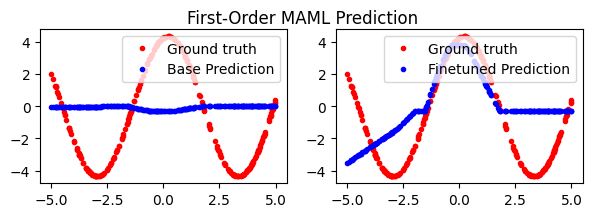

In [57]:
@jax.jit
def update_fn(train_state, batch): # MAML Update function.
    inner_steps = 1
    def maml_loss(task_params, train_x, train_y, val_x, val_y):
        def task_loss(params, x, y):
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for i in range(inner_steps): # Inner loop.
            model_grad = jax.grad(task_loss)(task_params, train_x, train_y)
            model_grad = jax.lax.stop_gradient(model_grad) # (ONLY CHANGE: Stop gradient here.)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
        loss = task_loss(task_params, val_x, val_y)
        return loss

    def loss_fn(grad_params): # Parallel map over K inner-loop tasks.
        maml_losses = jax.vmap(lambda task: maml_loss(grad_params, *task))(batch)
        return jnp.mean(maml_losses)

    l, g = jax.value_and_grad(loss_fn)(train_state.params) # Outer-loop gradient.
    updates, opt_state = train_state.opt.update(g, train_state.opt_state)
    params = optax.apply_updates(train_state.params, updates)
    train_state = train_state.replace(params=params, opt_state=opt_state)
    return train_state, {'loss': l}

# Train network on a *all* sine waves.
train_state = init_train_state() # Make a new model.
key = jax.random.PRNGKey(0)
for i in range(1000):
    id_key, sine_key, key = jax.random.split(key, 3)
    x, y = generate_sinusoids(sine_key, 16, 64) # 16 tasks, with 64 datapoints each.
    inner_train_x, inner_val_x = np.split(x, 2, axis=1)
    inner_train_y, inner_val_y = np.split(y, 2, axis=1)
    train_state, info = update_fn(train_state, (inner_train_x, inner_train_y, inner_val_x, inner_val_y))
y_pred_all = train_state.module.apply(train_state.params, x_single)

# 10-step finetune on a single sine wave.
def few_step_finetune(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)
for i in range(10):
    train_state = few_step_finetune(train_state, x_single[0, :64], y_single[0, :64])
y_pred_finetune = train_state.module.apply(train_state.params, x_single)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))
axs[0].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[0].plot(x_single[0], y_pred_all[0], 'b.', label='Base Prediction')
axs[1].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[1].plot(x_single[0], y_pred_finetune[0], 'b.', label='Finetuned Prediction')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
fig.suptitle('First-Order MAML Prediction')
plt.show()

## Reptile

Given that first-order MAML works decently well, **Reptile** is an extension that extends FOMAML to support multi-step inner loops. The idea is as follows:
- In the *inner loop*, take N gradient steps on task-specific data to get new task-specific parameters.
- In the *outer loop*, interpolate between the global parameters and the task-specific parameters.

**If N=1**, then Reptile is just equivalent to regular gradient descent (i.e. our naive implementation earlier). 

**If N=2**, Reptile looks more like FOMAML, with the slight difference that both inner-loop gradients are propagated back to the global parameters (as opposed to only the last validation gradient in FOMAML). We also don't have a separate training/validation split for each task. We just view all the data as the same.

**As N > 2**, Reptile can be seen as a way to empirically estimate second-order behavior through repeated iteration. Instead of computing the explicit Hessian, we simply take many steps during the inner loop, then propogate the *sum* of those changes back to the global parameters. Intuitively, this leads the global parameters to a point that is close to the optimal parameters for any downstream task.

In [81]:
@jax.jit
def update_fn_reptile(train_state, batch):
    inner_steps = 10
    def inner_reptile_params(task_params, train_x, train_y):
        def task_loss(params, x, y):
            pred = train_state.module.apply(params, x)
            return jnp.mean(jnp.square(pred - y))
        for i in range(inner_steps):
            inner_batchsize = train_x.shape[0] // inner_steps
            inner_x = train_x[i * inner_batchsize: (i + 1) * inner_batchsize]
            inner_y = train_y[i * inner_batchsize: (i + 1) * inner_batchsize]
            loss, model_grad = jax.value_and_grad(task_loss)(task_params, inner_x, inner_y)
            task_params = jax.tree_map(lambda p, g: p - 0.01 * g, task_params, model_grad)
        return loss, task_params

    train_x, train_y = batch # (32, 10, 1).
    loss, rparams = inner_reptile_params(train_state.params, train_x[0], train_y[0])
    stepsize = 0.1 # In paper, this number is annealed from one to zero.
    params = jax.tree_map(lambda p, r: p * (1-stepsize) + r * (stepsize), train_state.params, rparams) 
    train_state = train_state.replace(params=params)
    return train_state, {'loss': loss}

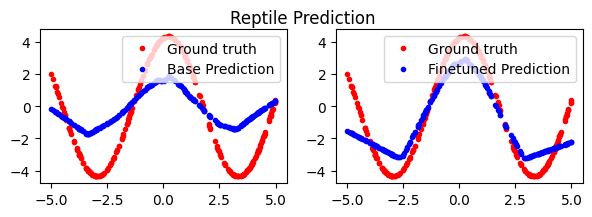

In [82]:
# Train network on a *all* sine waves.
train_state = init_train_state() # Make a new model.
key = jax.random.PRNGKey(0)
for i in range(10000):
    id_key, sine_key, key = jax.random.split(key, 3)
    x, y = generate_sinusoids(sine_key, 1, 256) # 1 tasks, with 256 datapoints.
    train_state, info = update_fn_reptile(train_state, (inner_train_x, inner_train_y))
y_pred_all = train_state.module.apply(train_state.params, x_single)

# 10-step finetune on a single sine wave.
def few_step_finetune(train_state, x, y):
    def loss_fn(params):
        pred = train_state.module.apply(params, x)
        return jnp.mean(jnp.square(pred - y))
    l, g = jax.value_and_grad(loss_fn)(train_state.params)
    params = jax.tree_map(lambda p, g: p - 0.01 * g, train_state.params, g)
    return train_state.replace(params=params)
for i in range(10):
    train_state = few_step_finetune(train_state, x_single[0, :64], y_single[0, :64])
y_pred_finetune = train_state.module.apply(train_state.params, x_single)

fig, axs = plt.subplots(1, 2, figsize=(7, 2))
axs[0].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[0].plot(x_single[0], y_pred_all[0], 'b.', label='Base Prediction')
axs[1].plot(x_single[0], y_single[0], 'r.', label='Ground truth')
axs[1].plot(x_single[0], y_pred_finetune[0], 'b.', label='Finetuned Prediction')
axs[0].legend(loc='upper right')
axs[1].legend(loc='upper right')
fig.suptitle('Reptile Prediction')
plt.show()